In [1]:
import pandas as pd
import numpy as np
from numpy import e
import nest_asyncio
import sklearn
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict, OrderedDict
from clientClass import Client
from Server import Server
from phe import paillier
import sys
import matplotlib.pyplot as plt
import torch
import random
from time import time
import math
from scipy.special import expit
from os import path
import cryptotree

from dataFunction import import_data, new_df, data_prep, make_dummies
nest_asyncio.apply()
np.random.seed(10)
tf.random.set_seed(10)
tff.framework.set_default_context(tff.backends.native.create_thread_debugging_execution_context(clients_per_thread=50))

In [2]:
# del sys.modules['cryptotree']

# Make Dataframes for every dataset

In [3]:

cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)
df = new_df(cleveland_df, switzerland_df, va_df, hungarian_df)

In [4]:
hungarian_df = df[df.Location == 'Hungarian'].drop(columns=['Location'])
switzerland_df = df[df.Location == 'Switzerland'].drop(columns=['Location'])
cleveland_df = df[df.Location == 'Cleveland'].drop(columns=['Location'])
va_df = df[df.Location == 'VA'].drop(columns=['Location'])

In [12]:
torch.random.manual_seed(73)
random.seed(73)
n_clients = 4
df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []
for i in list(df_dict.keys()):
    location_data = df_dict.get(i)
    y = location_data.HeartDisease
    # y =  torch.tensor(location_data["HeartDisease"].values).float().unsqueeze(1)
    location_data = location_data.drop("HeartDisease", 'columns')
    cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    # location_data = make_dummies(location_data, cat_feat)
    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    location_data[numeric_feature_names] = (location_data[numeric_feature_names] - location_data[numeric_feature_names].mean()) / location_data[numeric_feature_names].std()
    x = location_data
    # x = torch.tensor(location_data.values).float()
    clients.append(Client(i, x, y, cat_feat))
# cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
# clients[0].X = make_dummies(clients[0].X, cat_feat)


X_train, X_test, y_train, y_test = train_test_split(clients[1].X, clients[1].y, test_size=0.2, random_state=42)

/var/folders/51/y971znh54m9glw4jwjryyvdh0000gn/T/ipykernel_11229/3474096456.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  location_data = location_data.drop("HeartDisease", 'columns')
/var/folders/51/y971znh54m9glw4jwjryyvdh0000gn/T/ipykernel_11229/3474096456.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  location_data = location_data.drop("HeartDisease", 'columns')
/var/folders/51/y971znh54m9glw4jwjryyvdh0000gn/T/ipykernel_11229/3474096456.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  location_data = location_data.drop("HeartDisease", 'columns')


# Encryption methods
-   Homomorphic Encryption (HE)
-   Differential Privacy (DP)
-   Secure Multiparty Computations (SMPC)

In [13]:
clients[1].X.fillna(0)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.461858,1.0,4.0,0.300991,0.749749,0.0,1.0,-0.482684,1.0,1.530454,2.0
1,-1.943470,1.0,4.0,-0.245922,0.304237,0.0,1.0,0.199915,0.0,-1.189103,2.0
2,0.082069,1.0,4.0,-0.136540,0.382857,0.0,1.0,0.791501,1.0,0.170676,3.0
3,-0.550912,1.0,4.0,0.410373,0.470212,0.0,1.0,1.201061,1.0,1.077195,1.0
4,0.841647,1.0,3.0,-1.339748,0.339179,1.0,2.0,-1.074270,1.0,-0.010628,2.0
...,...,...,...,...,...,...,...,...,...,...,...
193,0.335262,1.0,4.0,1.285434,-0.036448,0.0,1.0,0.700488,1.0,-1.189103,2.0
194,-1.690278,1.0,4.0,-0.027157,1.186525,0.0,0.0,0.154409,0.0,-1.189103,2.0
195,-0.677508,0.0,4.0,-0.409996,1.387442,1.0,1.0,1.428594,0.0,-1.189103,2.0
197,-0.550912,1.0,4.0,-0.683452,0.426534,1.0,1.0,-1.028763,0.0,-1.189103,2.0


# HE
- TenSEAL
- linear 


In [14]:
import tenseal as ts

def context():
    context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

context = context()

In [15]:
public_context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=1032193)
print("Is the context private?", ("Yes" if public_context.is_private() else "No"))
print("Is the context public?", ("Yes" if public_context.is_public() else "No"))

sk = public_context.secret_key()

# the context will drop the secret-key at this point
public_context.make_context_public()
print("Secret-key dropped")
print("Is the context private?", ("Yes" if public_context.is_private() else "No"))
print("Is the context public?", ("Yes" if public_context.is_public() else "No"))

Is the context private? Yes
Is the context public? No
Secret-key dropped
Is the context private? No
Is the context public? Yes


In [16]:
clients[0].X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.947160,1.0,1.0,0.756274,-0.264463,1.0,2.0,0.017169,0.0,1.085542,3.0
1,1.389703,1.0,4.0,1.608559,0.759159,0.0,2.0,-1.818896,1.0,0.396526,2.0
2,1.389703,1.0,4.0,-0.664201,-0.341717,0.0,2.0,-0.900864,1.0,1.343924,2.0
3,-1.929372,1.0,3.0,-0.096011,0.063869,0.0,0.0,1.634655,0.0,2.119067,3.0
4,-1.486829,0.0,2.0,-0.096011,-0.824558,0.0,2.0,0.978917,0.0,0.310399,1.0
...,...,...,...,...,...,...,...,...,...,...,...
298,-1.044285,1.0,1.0,-1.232391,0.334260,0.0,0.0,-0.769716,0.0,0.138144,2.0
299,1.500339,1.0,4.0,0.699455,-1.037008,1.0,0.0,-0.376274,0.0,2.032940,2.0
300,0.283345,1.0,4.0,-0.096011,-2.234453,0.0,0.0,-1.512885,1.0,0.138144,2.0
301,0.283345,0.0,2.0,-0.096011,-0.206522,0.0,2.0,1.066349,0.0,-0.895381,2.0


In [107]:
# plain_vector = [60, 66, 73, 81, 90]
# # parameters
# poly_mod_degree = 4096
# coeff_mod_bit_sizes = [40, 20, 40]
# ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# ctx_eval.global_scale = 2 ** 20
# # enc_x_test = [ts.ckks_vector(ctx_eval, clients[0].X[x]) for x in clients[0].X]
# ctx_eval.generate_galois_keys()
# # encrypted_vector = ts.bfv_vector(context, plain_vector)
# # print("We just encrypted our plaintext vector of size:", encrypted_vector.size())
# # encrypted_vector

# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [108]:
X_test

tensor([[-0.1592,  1.0000, -0.0960,  ...,  0.0000,  0.0000,  1.0000],
        [-0.0486,  1.0000, -1.2324,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.1727,  1.0000, -0.3801,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 0.2833,  1.0000, -0.0960,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.8365,  0.0000,  0.3585,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.6153,  0.0000,  1.4949,  ...,  0.0000,  0.0000,  1.0000]])

In [7]:
# x_test = torch.from_numpy(X_test.to_numpy().astype(np.float32))
# y_test = torch.from_numpy(y_test.to_numpy().astype(np.float32))
# x_train = torch.from_numpy(X_train.to_numpy().astype(np.float32))
# y_train = torch.from_numpy(y_train.to_numpy().astype(np.float32))

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [188]:
plain1 = ts.plain_tensor([1,2,3,4], [2,2])

print(" First tensor: Shape = {} Data = {}".format(plain1.shape, plain1.tolist()))


 First tensor: Shape = [2, 2] Data = [[1.0, 2.0], [3.0, 4.0]]


In [191]:
x_train.shape

torch.Size([242, 18])

In [185]:
# enc_x_train = [ts.ckks_tensor(ctx_training, x.tolist()) for x in x_train]
# enc_y_train = [ts.ckks_tensor(ctx_training, y.tolist()) for y in y_train]

In [7]:
enc_x_train = ts.ckks_tensor(context, X_train)
enc_y_train = ts.ckks_tensor(context, y_train)

In [ ]:
XX = enc_x_train.dot(enc_x_train.transpose())

In [10]:
XX = enc_x_train.dot(enc_x_train)

ValueError: can't multiply matrices

In [9]:
print(enc_x_train.shape)
print(enc_x_train.transpose().shape)

[242, 18]
[18, 242]


In [200]:
enc_x_train * enc_y_train

In [186]:
print(" Shape = {}".format(enc_x_train.shape))
print(" Encrypted Data = {}.".format(enc_x_train))


encrypted_tensor_from_np = ts.ckks_tensor(context, np.array([5,6,7,8]).reshape([2,2]))
print(" Shape = {}".format(encrypted_tensor_from_np.shape))

AttributeError: 'list' object has no attribute 'shape'

In [111]:
len(enc_y_train)

242

In [112]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

In [151]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
     # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        d = 0.5
        p = 3
        # sig = 2**(-3*p)*d*x**3 + 3*2**(-2*p)*d*x**2+3*2**(-p)*d*x +d
        # which fits the function pretty well in the range [-5,5]
        # return [sigmoid_approx(i) for i in enc_x]
        # .polyval([0.5, 0.197, 0, -0.004])
        return enc_x.polyval([0.5, 3*2**(-p)*d, 3*2**(-2*p)*d, 2**(-3*p)*d])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [152]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out
def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

Distribution on plain data:


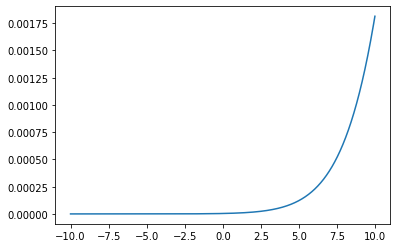

In [159]:
n_features = X_train.shape[1]
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()


In [161]:
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [164]:
def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optim.state_dict():
    print(var_name, "\t", optim.state_dict()[var_name])

Loss at epoch 1: 55.785125732421875
Loss at epoch 2: 55.785125732421875
Loss at epoch 3: 55.785125732421875
Loss at epoch 4: 55.785125732421875
Loss at epoch 5: 55.785125732421875
Model's state_dict:
lr.weight 	 torch.Size([1, 18])
lr.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[-8.1994e+00, -1.2280e-01, -1.8847e+01, -3.3834e+01, -2.1746e-02,
         -1.8546e+01, -9.1163e-02, -2.6496e-01, -8.1812e-03, -1.1681e-01,
         -1.1503e-02, -1.7465e-03, -8.4991e-02, -5.1008e-02, -2.2408e-03,
         -1.0930e-02, -1.0479e-01, -2.2518e-02]])}, 1: {'momentum_buffer': tensor([-0.1382])}}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'params': [0, 1]}]


In [165]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
plain_accuracy

tensor(0.5246)

In [173]:
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")
EPOCHS = 5
new_accuracy = 0

times = []
for epoch in range(EPOCHS):
    if path.exists('best-model-parameters.pt'):
        eelr = torch.load('best-model-parameters.pt')
    eelr.encrypt(ctx_training)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    if accuracy > new_accuracy :
        new_accuracy = accuracy
        torch.save(eelr, 'best-model-parameters.pt')
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optim.state_dict():
#     print(var_name, "\t", optim.state_dict()[var_name])

print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
print("The best accuracy:", new_accuracy)
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.5245901346206665
Accuracy at epoch #1 is 0.4754098355770111
Accuracy at epoch #2 is 0.5245901346206665
Accuracy at epoch #3 is 0.5245901346206665
Accuracy at epoch #4 is 0.4754098355770111
Accuracy at epoch #5 is 0.5245901346206665

Average time per epoch: 26 seconds
Final accuracy is 0.5245901346206665
Difference between plain and encrypted accuracies: 0.0
The best accuracy: tensor(0.5246)


In [ ]:
# linear regression
# y = alpha, beta*x + epsilon
# beta_hat = (x'x)^-1 x'y

In [181]:
len(enc_x_train)

242

In [184]:
np.dot(enc_x_train, enc_x_train)

In [ ]:
def return_transpose(mat):
    return map(list,zip(*mat))

def return_matrix_minor(mat,i,j):
    return [row[:j] + row[j+1:] for row in (mat[:i]+mat[i+1:])]

def return_determinant(mat):
    if len(mat) == 2:
        return mat[0][0]*mat[1][1]-mat[0][1]*mat[1][0]

    determinant = 0
    for c in range(len(m)):
        determinant += ((-1)**c)*m[0][c]*return_determinant(return_matrix_minor(m,0,c))
    return determinant

def inverse_matrix(m):
    determinant = return_determinant(m)
    if len(m) == 2:
        return [[m[1][1]/determinant, -1*m[0][1]/determinant],
                [-1*m[1][0]/determinant, m[0][0]/determinant]]

    cfs = []
    for r in range(len(m)):
        cfRow = []
        for c in range(len(m)):
            minor = return_matrix_minor(m,r,c)
            cfRow.append(((-1)**(r+c)) * return_determinant(minor))
        cfs.append(cfRow)
    cfs = return_transpose(cfs)
    for r in range(len(cfs)):
        for c in range(len(cfs)):
            cfs[r][c] = cfs[r][c]/determinant
    return cfs

m = [[4,3],[8,5]]
print(inverse_matrix(m))

In [263]:
# Define class for logistic regression with stochastic gradient descent

class LogisticRegression:
    def __init__(self, start, lr=0.01):
        self.lr = lr
        self.beta = start
    
    def __sigmoid(self, z):
        return 1 / (1 + e**(-1*z))
    
    def __loss(self, p, y):
        return (-y * np.log(p) - (1 - y) * np.log(1 - p)).sum()
    
    def fit(self, X, y):      
        z = np.dot(X, self.beta)
        p = self.__sigmoid(z)
        gradient = np.dot(X.T, (p - y)) / y.size
        self.beta -= self.lr * gradient
        loss = self.__loss(p, y)
        
    def predict_prob(self, X):
        return self.__sigmoid(np.dot(X, self.beta))
    
    def predict_loss(self, X, y):   
        p = self.__sigmoid(np.dot(X, self.beta))
        return self.__loss(p, y)
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    
    def beta(self):
        return self.beta
        
    
def log_loss_NB(naive_bayes_model, X, y):
    p = naive_bayes.predict_proba(chunk_test)[:,1]
    return (-y * np.log(p) - (1 - y) * np.log(1 - p)).sum()

In [338]:
# from sklearn.linear_model import LogisticRegression
# encrypt_vector(clients[0].pubkey, clients[0].X['Age'])
# model = LogisticRegression()
# model.fit(X_train ,y_train)
# clients[0].X.iloc[:,1:]
# logistic_regression = LogisticRegression(lr=0.1, start = np.zeros(clients[0].X.shape[1]+1)) # Initialize regression object

In [522]:
X_train, X_test, y_train, y_test = train_test_split(clients[0].X, clients[0].y, test_size=0.2, random_state=42)

In [435]:
clients[0].y = encrypt_vector(clients[0].pubkey, clients[0].y)

In [428]:
for feature in clients[0].X.columns:
    feature_name = feature + '_encrypt'  
    encrypt = pd.Series(encrypt_vector(clients[0].pubkey, clients[0].X[feature]), name=feature_name )
    clients[0].X = pd.concat([clients[0].X, encrypt], axis=1)
    clients[0].X = clients[0].X.drop(feature, axis = 1)

In [439]:
# y_train

In [229]:
X_train = np.hstack((X_train, np.atleast_2d(encryp_var).T))

In [287]:
# for i in X_train:
#     print(i)
beta = np.zeros(clients[0].X.shape[1]+1)
z = np.dot(X_train, beta)
z[0].ciphertext()

9562283392411349110533454692164736441637392448349508354186222223585670184584081709419827656104449425454822269499970882819351678044689137190392369305737491392239374065549763211001313602286120525498874283017517217456934472612078199408405665000801333478723092406845006671735725922261143982982648329047798796147446386239313571436987650323375709813449064873285772628463086053100118868967585347372650102619117044276551450703896535253071798596720534441400791516808209669090787237514542359078567479460171894683516695797688360422529194793402586460553349635597181786208429685580196957033921913552585264315413070894817681139936721297392458539170781133847828603254566678378291439764869160490293783654532861356878232816275080610710184297348461103461250643393138954066843811045202892258005431329100049719532257083429912067362431398401350578028891509247160494982723510891315827906839801771426118292302565353813298995581058239621821708013692208564027367557070934374013210329691678183188563229627418141338912680807056

In [594]:

pubkey, privkey = paillier.generate_paillier_keypair(n_length=60)
age1 = X_train[0][0]

M1 = pubkey.encrypt(age1)
print(M1.ciphertext())
# print(clients[0].pubkey.encrypt(X_train[0][0]))

KeyError: 0

In [319]:
X_train[0][0]

-2.8191147424276726

In [339]:
# pubkey, privkey = paillier.generate_paillier_keypair(n_length=50)
# pubkey.encrypt(2.1).ciphertext()

In [606]:
x_tttt =1
y_tttt =3
X_tttt_en = pubkey.encrypt(1/x_tttt)
privkey.decrypt(y_tttt*X_tttt_en)


3.0

In [602]:
pubkey.encrypt(3).ciphertext()

102930719792505648782677451942371551

In [597]:
# encryp_var = encrypt_vector(clients[0].pubkey,X_train[:,0])

# Differential privacy


In [343]:
tf.compat.v1.disable_v2_behavior()

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

tf.get_logger().setLevel('ERROR')

In [449]:
for i in X_train:
    for j in X_train[i]:
        X_train[i] = j.ciphertext()



In [454]:
for i in X_test:
    for j in X_test[i]:
        X_test[i] = j.ciphertext()


In [479]:
# for i in range(len(y_train)+1):
#     if 
#     y_train[i] = y_train[i].ciphertext()

In [452]:
# y_train = [i.ciphertext() for i in y_train]

In [458]:
type(y_train[0])

int

In [455]:
y_test = [i.ciphertext() for i in y_test]

In [463]:
y_test[0]

398851416007926900744051775508806248

## Random forest

In [390]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

In [527]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}

RF_model = RandomForestClassifier(**parameters)
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=50)

In [528]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=50)

In [529]:
RF_predictions = RF_model.predict(X_test)
score = accuracy_score(y_test ,RF_predictions)
print(score)

0.7868852459016393


## Neural network

In [530]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

    

In [546]:
clients[0].X.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1.0', 'ChestPainType_4.0',
       'ChestPainType_3.0', 'ChestPainType_2.0', 'RestingECG_2.0',
       'RestingECG_0.0', 'RestingECG_1.0', 'ST_Slope_3.0', 'ST_Slope_2.0',
       'ST_Slope_1.0'],
      dtype='object')

In [568]:
feature_columns = []
for i in cleveland_df:  
    if i != 'HeartDisease':
        feature_columns.append(tf.feature_column.numeric_column(i))

In [559]:
def create_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('HeartDisease')
  return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) \
          .shuffle(buffer_size=len(dataframe)) \
          .batch(batch_size)

In [563]:
RANDOM_SEED =20
train, test = train_test_split(
  cleveland_df,
  test_size=0.2,
  random_state=RANDOM_SEED
)

train_ds = create_dataset(train)
test_ds = create_dataset(test)

In [562]:
cleveland_df = make_dummies(cleveland_df, cat_feat)

In [591]:
model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_columns),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=2, activation='sigmoid')
])

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=test_ds, epochs=300, verbose=True, use_multiprocessing=True)

Train on 8 steps, validate on 2 steps
Epoch 1/300
8/8 [==============================] - 1s 76ms/step - batch: 3.5000 - size: 1.0000 - loss: 3.8471 - acc: 0.5248 - val_loss: 1.5072 - val_acc: 0.5492
Epoch 2/300
8/8 [==============================] - 0s 5ms/step - batch: 3.5000 - size: 1.0000 - loss: 2.4917 - acc: 0.5103 - val_loss: 0.6828 - val_acc: 0.6230
Epoch 3/300
8/8 [==============================] - 0s 5ms/step - batch: 3.5000 - size: 1.0000 - loss: 2.0681 - acc: 0.5475 - val_loss: 0.8695 - val_acc: 0.5902
Epoch 4/300
8/8 [==============================] - 0s 5ms/step - batch: 3.5000 - size: 1.0000 - loss: 1.8045 - acc: 0.5269 - val_loss: 0.7741 - val_acc: 0.5984
Epoch 5/300
8/8 [==============================] - 0s 5ms/step - batch: 3.5000 - size: 1.0000 - loss: 1.5167 - acc: 0.5517 - val_loss: 0.5706 - val_acc: 0.7459
Epoch 6/300
8/8 [==============================] - 0s 5ms/step - batch: 3.5000 - size: 1.0000 - loss: 1.4020 - acc: 0.5351 - val_loss: 0.6567 - val_acc: 0.6311
E

In [541]:
checkpoint_name = 'Weights-{epoch:03d}-{val_acc:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_acc', verbose = 1, save_best_only = True, mode ='max')
callbacks_list = [checkpoint]

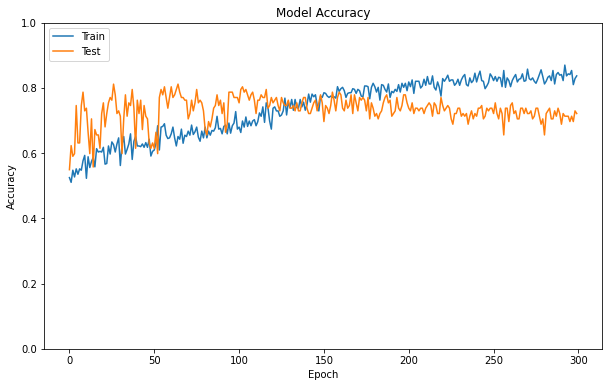

In [592]:
plt.figure(figsize =(10, 6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim((0, 1))
plt.legend(['Train', 'Test'], loc='upper left');

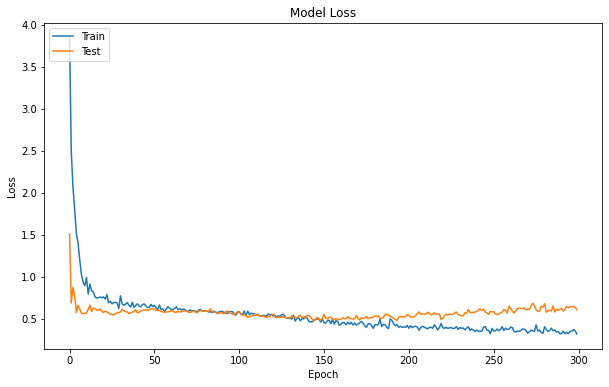

In [593]:
plt.figure(figsize =(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [589]:
predictions = model.predict(test_ds)
# bin_predictions = 
# predictions)
predictions

array([[0.4933114 , 0.4891999 ],
       [0.6117399 , 0.62835884],
       [0.06430629, 0.07348382],
       [0.21639809, 0.22788242],
       [0.8365073 , 0.85269797],
       [0.78826594, 0.7596522 ],
       [0.5529521 , 0.5331757 ],
       [0.15697879, 0.16361171],
       [0.1405516 , 0.12736943],
       [0.8608403 , 0.8599888 ],
       [0.02447352, 0.0307447 ],
       [0.6688445 , 0.63541085],
       [0.71244365, 0.70871675],
       [0.29859334, 0.3155767 ],
       [0.06000218, 0.05644387],
       [0.25270712, 0.23295355],
       [0.8485402 , 0.87899065],
       [0.02366969, 0.0358175 ],
       [0.32671463, 0.3145962 ],
       [0.31574047, 0.30341312],
       [0.03280753, 0.03214249],
       [0.8455738 , 0.8236328 ],
       [0.4953224 , 0.48924914],
       [0.00566015, 0.00538138],
       [0.42457077, 0.42215464],
       [0.93734556, 0.9455478 ],
       [0.9331922 , 0.9247814 ],
       [0.03458381, 0.04731491],
       [0.827996  , 0.83502746],
       [0.18881142, 0.20797423],
       [0.

In [542]:
X_train

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_1.0,ChestPainType_4.0,ChestPainType_3.0,ChestPainType_2.0,RestingECG_2.0,RestingECG_0.0,RestingECG_1.0,ST_Slope_3.0,ST_Slope_2.0,ST_Slope_1.0
132,29.0,1.0,130.0,204.0,0.0,202.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1
202,57.0,1.0,150.0,126.0,1.0,173.0,0.0,0.2,0,0,1,0,0,1,0,0,0,1
196,69.0,1.0,160.0,234.0,1.0,131.0,0.0,0.1,1,0,0,0,1,0,0,0,1,0
75,65.0,0.0,160.0,360.0,0.0,151.0,0.0,0.8,0,0,1,0,1,0,0,0,0,1
176,52.0,1.0,108.0,233.0,1.0,147.0,0.0,0.1,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,54.0,1.0,192.0,283.0,0.0,195.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1
71,67.0,1.0,125.0,254.0,1.0,163.0,0.0,0.2,0,1,0,0,0,1,0,0,1,0
106,59.0,1.0,140.0,177.0,0.0,162.0,1.0,0.0,0,1,0,0,0,1,0,0,0,1
270,61.0,1.0,140.0,207.0,0.0,138.0,1.0,1.9,0,1,0,0,1,0,0,0,0,1


In [570]:
model.evaluate(test_ds)

[0.579225480556488, 0.704918]

In [574]:
predictions = tf.round(model.predict(test_ds))
predictions

<tf.Tensor 'Round_3:0' shape=(61, 2) dtype=float32>

In [543]:
NN_model.fit(X_train, y_train, epochs=10)

ValueError: Dimension size must be evenly divisible by 250 but is 1 for '{{node training_12/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](loss_20/mul, training_12/Reshape/shape)' with input shapes: [], [2] and with input tensors computed as partial shapes: input[1] = [250,?].

In [486]:
wights_file = './Weights-001-0.00000.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

In [491]:
y_train

[246319264148350358054669534987564173,
 177143461162040986851238976625108796,
 104812875922599433366178452340603918,
 178735323088735587838392349074683859,
 400586047243761177018558630754787647,
 64172410500943263505116508828072672,
 299228703610430305541100979502054017,
 320799565348619493446226659768112545,
 375958792426658685251948079487254474,
 146265733836052760139673702806348250,
 366414248620061194346475527046056571,
 393074351233137245268163578954865652,
 382035551214240326522065345326611112,
 373668759174376824953887084838549949,
 184792494315522827260270469318561352,
 390620943805124658977982345808440914,
 390054895760771789437971920745822774,
 257429311603635885765375570812073054,
 320784359760704950360125539925782488,
 122843032277651636956766112339680319,
 213616313964191207536875195965187077,
 120836570035771770819408863119288023,
 166666184910251508623329212138813915,
 392352656625530820349923204654925079,
 54916066556507139919176612870723182,
 40485536771777163054741522

In [487]:
predictions = NN_model.predict(X_test)
# round predictions
rounded = [round(x[0]) for x in predictions]
predictions = rounded
score = accuracy_score(y_test ,predictions)
print(score)

/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [219]:
from cryptotree.preprocessing import Featurizer

pipe = Featurizer(cat_feat)
X_train_normalized = pipe.fit_transform(X_train)

In [220]:
X_test_normalized = pipe.fit_transform(X_test)

In [221]:
import torch
import numpy as np

/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/cryptotree/polynomials.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

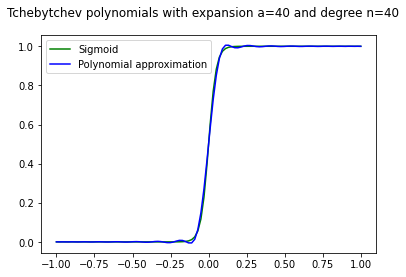

In [266]:
from cryptotree.tree import NeuralRandomForest, SigmoidTreeMaker, TanhTreeMaker
from cryptotree.polynomials import plot_graph_function_approximation

max_depth = 4

dilatation_factor = 40
polynomial_degree = dilatation_factor

plot_graph_function_approximation(torch.sigmoid,
                                  dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

In [267]:
sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

In [268]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#  max_depth=None, max_features='auto', max_leaf_nodes=None,
#  min_samples_leaf=90,
#  min_samples_split=0.5, min_weight_fraction_leaf=0.0,
#  n_estimators=12, n_jobs=1, oob_score=False, random_state=None,
#  verbose=0, warm_start=False)

rf = RandomForestClassifier(max_depth=8, min_samples_split=0.5,n_estimators=12,random_state=0)
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=0.5, n_estimators=12,
                       random_state=0)

In [269]:
estimators = rf.estimators_

In [270]:
sigmoid_neural_rf = NeuralRandomForest(estimators, sigmoid_tree_maker)
tanh_neural_rf = NeuralRandomForest(estimators, tanh_tree_maker)

/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [271]:
with torch.no_grad():
    sigmoid_neural_pred = sigmoid_neural_rf(torch.tensor(X_test_normalized).float()).argmax(dim=1).numpy()
    tanh_neural_pred = tanh_neural_rf(torch.tensor(X_test_normalized).float()).argmax(dim=1).numpy()

pred = rf.predict(X_test_normalized)
print(f"Original accuracy : {np.mean(pred == y_test)}")

print(f"Accuracy of sigmoid  : {np.mean(sigmoid_neural_pred == y_test)}")
print(f"Accuracy of tanh : {np.mean(tanh_neural_pred == y_test)}")

print(f"Match between sigmoid and original : {np.mean(sigmoid_neural_pred == pred)}")
print(f"Match between tanh and original : {np.mean(tanh_neural_pred == pred)}")

Original accuracy : 0.7540983606557377
Accuracy of sigmoid  : 0.819672131147541
Accuracy of tanh : 0.819672131147541
Match between sigmoid and original : 0.9016393442622951
Match between tanh and original : 0.9016393442622951


In [260]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7683189655172413

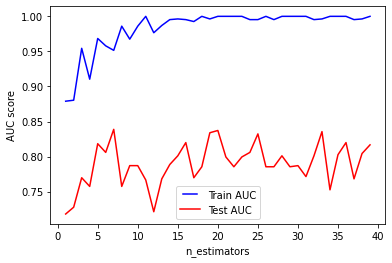

In [261]:
# n_estimators = [1, 2, 4, 8, 12, 16, 20, 24, 28 ,30, 40 ,50, 60 ,80]
n_estimators = range(1,40)
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

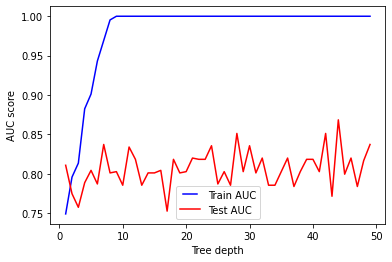

In [262]:
max_depths = range(1,50)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

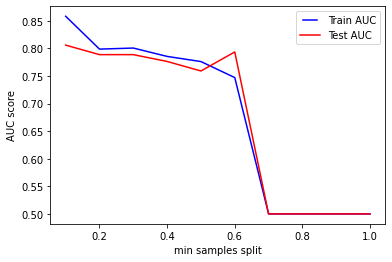

In [263]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()